In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local")
spark = SparkSession.builder.getOrCreate()

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import numpy as np

# Simple linear regression
Linear regression with only a slope, also known as simple linear regression, is a statistical technique used to model the relationship between a dependent variable and an independent variable when the relationship can be approximated by a straight line. In this case, we are considering a linear regression model with a single predictor variable and no intercept term.

To perform linear regression with only a slope, we need a set of paired observations (x, y), where x represents the independent variable (predictor) and y represents the dependent variable (response). The goal is to estimate the slope of the line that best fits the data points.

The formula for the simple linear regression model is:

$$y = \beta \cdot x + \epsilon$$

where:
- y is the dependent variable
- x is the independent variable
- β is the slope of the line
- ε is the error term representing the random variation or noise in the data

## Generate data

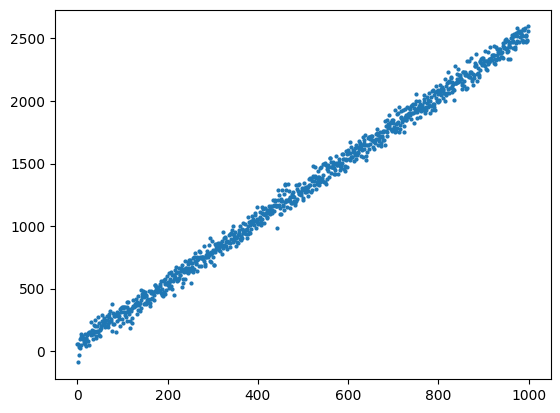

In [11]:
# Let us create some random data
size= 1000
mu, sigma = 50, 50 # mean and standard deviation
error=np.random.normal(mu, sigma, size)
x1 = np.arange(0, size)
y = 2.5*x1 + error
plt.plot(x1, y, 'o', markersize=2)
plt.show()

In [12]:
myRDD = sc.parallelize(zip(y,x1))
myRDD.take(5)

[(59.783506268246036, 0),
 (60.24254936278431, 1),
 (-90.04213856593617, 2),
 (-28.382081986738385, 3),
 (32.894155679929774, 4)]

## Calculating the slope using sklearn. 
The fit() method returns an instance of the LinearRegression class, which contains the slope of the line in its coef_ attribute.

In [13]:
from sklearn.linear_model import LinearRegression

X = np.stack([x1], axis=1)
reg = LinearRegression(fit_intercept=False).fit(X, y)
print(reg.coef_)

[2.57832511]


## Calculating the slope using linear algebra.
Calculate the coefficients of a linear regression model using the normal equation approach

$$
\hat{\beta} = (X^T \cdot X)^{-1} \cdot X^T \cdot y
$$

Where:
- $\hat{\beta}$ represents the estimated coefficients of the linear regression model.
- $X$ is the matrix of input variables.
- $X^T$ denotes the transpose of $X$.
- $y$ is the vector of dependent variable values.
- $(X^T \cdot X)^{-1}$ represents the inverse of the matrix product $X^T \cdot X$.

In [14]:
# Let use solve this also with the exact linear algebra solution. 
beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(beta_hat)

[2.57832511]


## Calculating the slope using gradient descent
Gradient descent is an iterative optimization algorithm used to find the minimum value of a function. In the context of machine learning, we can use gradient descent to find the optimal values of the coefficients in a parameterized model.

1. Calculation of the prediction with current regression coefficients:
   - Prediction: $y_{\text{prediction}} = m_{\text{current}} \cdot x_1$

2. Computation of the cost (for monitoring purposes):
   - Cost: $cost = \sum (y - y_{\text{prediction}})^2$

3. Calculation of the gradient:
   - Gradient: $m_{\text{gradient}} = \frac{-1}{n} \sum (x_1 \cdot (y - y_{\text{prediction}}))$

4. Update of the regression coefficient:
   - Updated coefficient: $m_{\text{current}} = m_{\text{current}} - \text{learningRate} \cdot m_{\text{gradient}}$

Here, the variable $n$ represents the number of data points in the dataset, $y$ is the dependent variable, $x_1$ is the independent variable, $m_{\text{current}}$ is the current value of the coefficient, and $\text{learningRate}$ is the learning rate (step size) used in the gradient descent algorithm.

In [15]:
# Now, we do gradient descent here with a very simple numpy array 
learningRate = 0.000001
num_iteration = 30 
m_current=0
n = float(size)

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    # Calculate the prediction with current regression coefficients. 
    y_prediction = m_current * x1 
    # We compute costs just for monitoring 
    cost= sum (( y - y_prediction)**2)
    # calculate gradients. 
    m_gradient = (-1.0/n) * sum (x1 * (y - y_prediction) )
    print(i , "m=", m_current, " Cost=", cost)
    # update the weights - Regression Coefficients 
    m_current = m_current - learningRate * m_gradient 

0 m= 0  Cost= 2215636543.5443425
1 m= 0.8581529700132395  Cost= 987890919.7845489
2 m= 1.430683883481578  Cost= 441407667.1315686
3 m= 1.812657329162052  Cost= 198161884.25056136
4 m= 2.067497216009634  Cost= 89890476.84301123
5 m= 2.237517851378131  Cost= 41697667.400776125
6 m= 2.350949923604708  Cost= 20246511.111718275
7 m= 2.42662800221986  Cost= 10698362.50898688
8 m= 2.4771178810562557  Cost= 6448375.211735814
9 m= 2.5108030368049583  Cost= 4556658.526301279
10 m= 2.533276644267775  Cost= 3714634.3583076335
11 m= 2.5482702823011163  Cost= 3339840.0220603356
12 m= 2.5582735353100876  Cost= 3173014.88826665
13 m= 2.564947370608697  Cost= 3098759.162996252
14 m= 2.569399929946447  Cost= 3065707.112564496
15 m= 2.5723705283758562  Cost= 3050995.27675971
16 m= 2.57435241213291  Cost= 3044446.8747719517
17 m= 2.575674658582511  Cost= 3041532.108106369
18 m= 2.5765568171184285  Cost= 3040234.71299674
19 m= 2.577145363741282  Cost= 3039657.2279821215
20 m= 2.5775380223317375  Cost= 3039

## Calculating the slope using gradient descent in PySpark
- `myRDD` contains tuples with the dependent variable $y$ as the first element (`x[0]`) and the independent variable $x$ as the second element (`x[1]`). 
- `size` represents the size of the RDD
- `learningRate` represents the learning rate (step size) used in the gradient descent algorithm.
- `beta` represents the current value of the coefficient.
- `gradient` represents the gradient of the cost function.
- `cost` represents the cost of the current loss function.

In [16]:
# Now we do gradient Decent on our RDD data set. 
learningRate = 0.000001
num_iteration = 30 

beta = 0
myRDD.cache()

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    
    gradientCost=myRDD.map(lambda x: (x[1], (x[0] - x[1] * beta) ))\
                        .map(lambda x: (x[0]*x[1], x[1]**2 ))\
                        .reduce(lambda x, y: (x[0] +y[0], x[1]+y[1] ))
    cost= gradientCost[1]/(2*size)
    gradient=(-1.0/float(size))* gradientCost[0]
    print(i, "Beta", beta, " Cost", cost)
    beta = beta - learningRate * gradient    

0 Beta 0  Cost 1107818.2717721714
1 Beta 0.8581529700132395  Cost 493945.45989227446
2 Beta 1.430683883481578  Cost 220703.8335657843
3 Beta 1.812657329162052  Cost 99080.94212528068
4 Beta 2.067497216009634  Cost 44945.238421505615
5 Beta 2.237517851378131  Cost 20848.833700388062
6 Beta 2.350949923604708  Cost 10123.255555859138
7 Beta 2.42662800221986  Cost 5349.181254493439
8 Beta 2.4771178810562557  Cost 3224.1876058679068
9 Beta 2.5108030368049583  Cost 2278.3292631506392
10 Beta 2.533276644267775  Cost 1857.3171791538168
11 Beta 2.5482702823011163  Cost 1669.9200110301679
12 Beta 2.5582735353100876  Cost 1586.507444133325
13 Beta 2.564947370608697  Cost 1549.379581498126
14 Beta 2.569399929946447  Cost 1532.853556282248
15 Beta 2.5723705283758562  Cost 1525.497638379855
16 Beta 2.57435241213291  Cost 1522.2234373859758
17 Beta 2.575674658582511  Cost 1520.7660540531847
18 Beta 2.5765568171184285  Cost 1520.1173564983699
19 Beta 2.577145363741282  Cost 1519.8286139910608
20 Beta 